# Fine-tune  Visual Question Answering using Consumer GPU with QLoRA


In [1]:
!nvidia-smi

Tue Dec 24 23:12:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:C1:00.0 Off |                  Off |
| 36%   46C    P5             49W /  450W |       2MiB /  24564MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install flash-attn --no-build-isolation 
!pip install -U triton
!pip install -U bitsandbytes


#!pip install -q accelerate datasets peft bitsandbytes tensorboard

# Clean up the notebook
clean_notebook()



Notebook cleaned.


We will push out model to Hub so we need to authenticate ourselves.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from datasets import load_dataset
ds = load_dataset('merve/vqav2-small', trust_remote_code=True).pop("validation")
split_ds = ds.train_test_split(test_size=0.3)
train_ds = split_ds["train"]
val_ds  = split_ds["test"]

In [5]:
train_ds

Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 15004
})

In [6]:
val_ds

Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 6431
})

In [7]:
train_ds[0]

{'multiple_choice_answer': 'yes',
 'question': 'Are they making sundaes?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=425x640>}

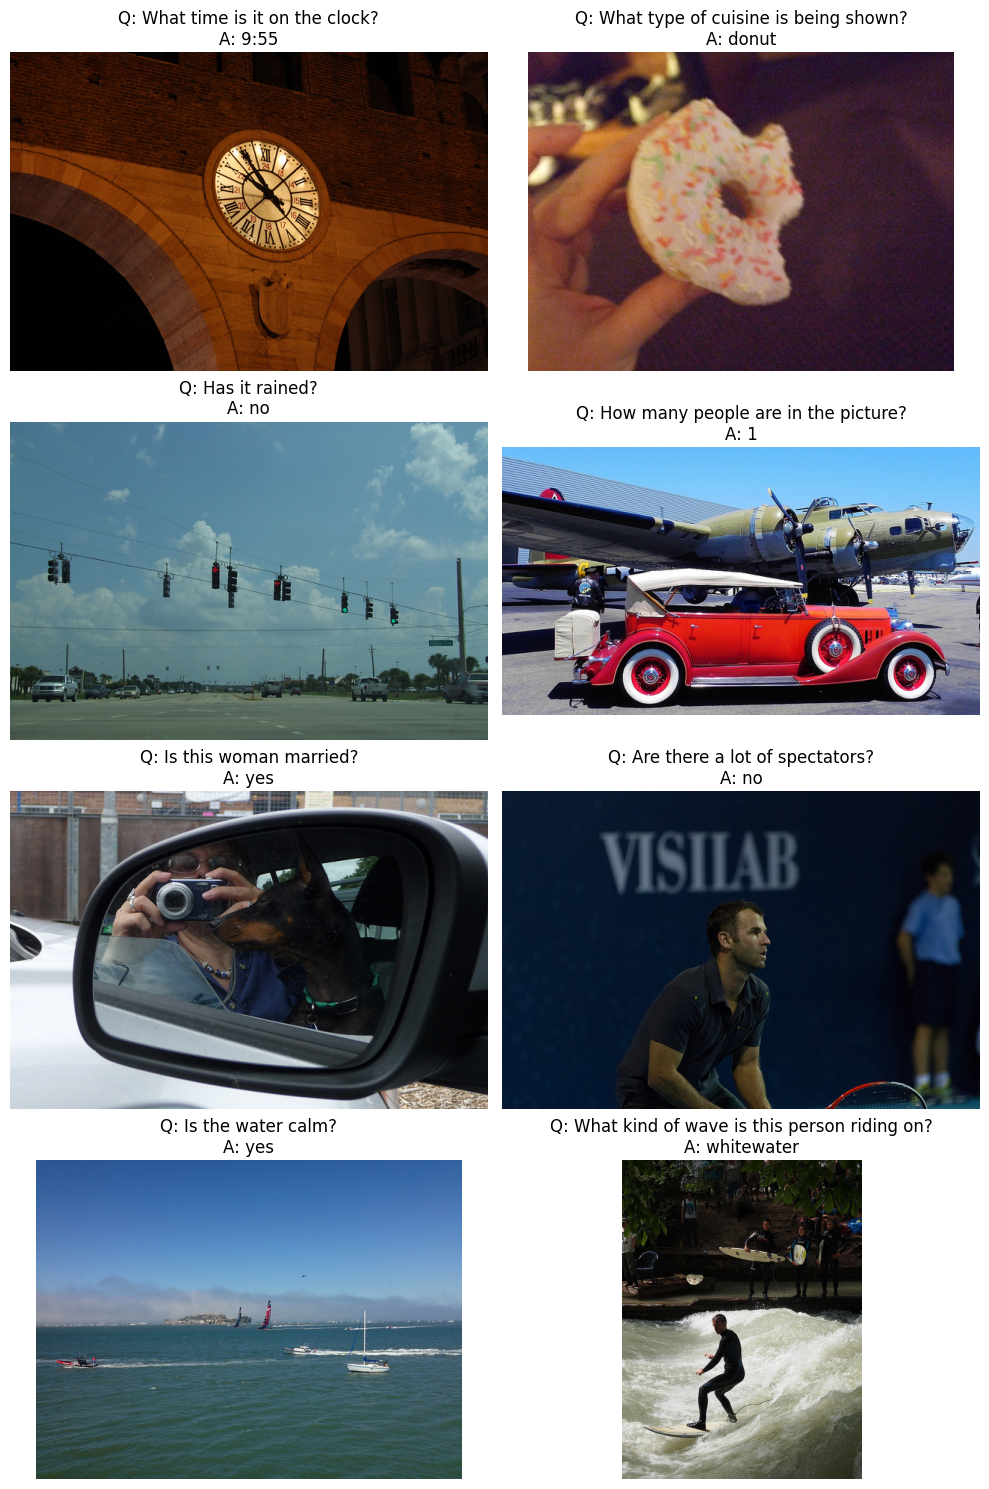

In [8]:
import random
import matplotlib.pyplot as plt

def random_plot(dataset, rows=2, cols=2, figsize=(10, 10)):
    """
    Displays a grid of random examples from the dataset.

    Parameters:
        dataset (list): A list of dictionaries where each dictionary contains 'image', 'question', and 'multiple_choice_answer'.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.

    Returns:
        None
    """
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    for i in range(rows):
        for j in range(cols):
            idx = random.randint(0, len(dataset) - 1)
            example = dataset[idx]
            img = example['image']
            question = example['question']
            answer = example['multiple_choice_answer']

            axs[i, j].imshow(img)
            axs[i, j].set_title(f"Q: {question}\nA: {answer}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:

random_plot(train_ds, rows=4, cols=2, figsize=(10, 15))


In this notebook we will not do full fine-tuning but use QLoRA method, which loads an adapter to the quantized version of the model, saving space. If you want to do full fine-tuning, set `USE_LORA` and `USE_QLORA` to False. If you want to do LoRA, set `USE_QLORA` to False and `USE_LORA` to True.

In [9]:
import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration

USE_LORA = True
USE_QLORA = True

model_id = "HuggingFaceM4/Idefics3-8B-Llama3"
processor = AutoProcessor.from_pretrained(model_id)


# Check if CUDA is available and set the device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")



if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    lora_config.inference_mode = False
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        quantization_config=bnb_config if USE_QLORA else None,
        _attn_implementation="flash_attention_2",
        device_map="auto"
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model.get_nb_trainable_parameters())
else:
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation="flash_attention_2",
    ).to(device)

    # if you'd like to only fine-tune LLM
    for param in model.model.vision_model.parameters():
        param.requires_grad = False




Using device: NVIDIA GeForce RTX 4090


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

(22464512, 8484550896)


In [10]:

# Print device mapping (if using device_map="auto")
if hasattr(model, 'hf_device_map'):
    print("Device Map:", model.hf_device_map)

# Check memory usage on each GPU
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(i) / 1e9:.2f} GB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated(i) / 1e9:.2f} GB")
    print(f"Memory Reserved: {torch.cuda.memory_reserved(i) / 1e9:.2f} GB")
    print(f"Max Memory Reserved: {torch.cuda.max_memory_reserved(i) / 1e9:.2f} GB")

Device Map: {'model.vision_model': 0, 'model.connector': 0, 'model.text_model.embed_tokens': 0, 'model.text_model.layers.0': 0, 'model.text_model.layers.1': 0, 'model.text_model.layers.2': 0, 'model.text_model.layers.3': 0, 'model.text_model.layers.4': 0, 'model.text_model.layers.5': 0, 'model.text_model.layers.6': 0, 'model.text_model.layers.7': 1, 'model.text_model.layers.8': 1, 'model.text_model.layers.9': 1, 'model.text_model.layers.10': 1, 'model.text_model.layers.11': 1, 'model.text_model.layers.12': 1, 'model.text_model.layers.13': 1, 'model.text_model.layers.14': 1, 'model.text_model.layers.15': 1, 'model.text_model.layers.16': 1, 'model.text_model.layers.17': 1, 'model.text_model.layers.18': 1, 'model.text_model.layers.19': 1, 'model.text_model.layers.20': 1, 'model.text_model.layers.21': 1, 'model.text_model.layers.22': 1, 'model.text_model.layers.23': 1, 'model.text_model.layers.24': 1, 'model.text_model.layers.25': 1, 'model.text_model.layers.26': 1, 'model.text_model.layer

Let's write our data collating function. We will apply prompt template to have questions and answers together so model can learn to answer. Then we pass the formatted prompts and images to the processor which processes both.

In [11]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = example["image"]
      if image.mode != 'RGB':
        image = image.convert('RGB')
      question = example["question"]
      answer = example["multiple_choice_answer"]
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": "Answer briefly."},
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

## Training

We can now initialize `Trainer` and initialize `TrainingArguments` to pass to `Trainer`.

Some notes:
- If you use 8-bit QLoRA with the below setup it uses around 16.4 GB VRAM (beautiful, fits comfortably inside L4, Colab free tier)
- We use gradient accumulation to simulate a larger batch size.
- We also save up on memory from intermediate activations by using gradient checkpointing.

**Disclaimer:** 
The techniques here aren't free lunch. The latter two will add additional compute to the training, thus slow down a bit (for reference on two A100s with bsz of 16, we were able to train for 2 hrs 43 mins with the gradient accumulation steps of 4, disabling it reduced it with 2 hr 35 mins). 
If you want to speed-up, you might play around, reduce to 4-bit precision and have a higher batch size. Note that 4-bit might result in model learning less.

In [13]:
from transformers import TrainingArguments, Trainer

model_name = model_id.split("/")[-1]


# Disable use_cache if gradient checkpointing is enabled
model.config.use_cache = False

# # Mixed precision: ensure proper casting for BF16
if torch.cuda.is_available() :
     model = model.to(torch.bfloat16)
     for name, module in model.named_modules():
        if isinstance(module, torch.nn.LayerNorm):
            module = module.to(torch.bfloat16)
        if isinstance(module, torch.nn.Embedding):
            module = module.to(torch.bfloat16)


training_args = TrainingArguments(
    num_train_epochs=1,  # Increase epochs
    per_device_train_batch_size=2,  # Adjust based on memory
    gradient_accumulation_steps=12,  # Maintain effective batch size
    optim="paged_adamw_8bit", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    warmup_steps=50,  # Adjust warmup
    learning_rate=1e-4,
    lr_scheduler_type="cosine",  # Cosine annealing
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=2,  # Reduce checkpoint storage
    output_dir=f"./{model_name}-vqav2",
    remove_unused_columns=False,
    
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=val_ds,  # Add your validation dataset here

  
)

In [ ]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
The input hidden states seems to be silently casted in float32, this might be related to the fact you have upcasted embedding or layer norm layers in float32. We will cast back the input in torch.bfloat16.


Step,Training Loss


In [ ]:
trainer.push_to_hub()